# Vehicle Detection from images, videos, and Real-time detection with our trained model of custom dataSet with TensorFlow 2 Detection Model Zoo.

In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import pandas as pd
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 1. Load Train Model From Checkpoint

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobilenet_v2_fpnlite_320x320' 
LABEL_MAP_NAME = 'label_map.pbtxt'
CHECKPOINT_NAME = 'ckpt-51'


In [3]:
paths = {
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'],CHECKPOINT_NAME )).expect_partial()

# Set the minimum detection score threshold
min_score_thresh = 0.6
def detect_fn(image):
    '''
    takes an image in tensor type and return detections
    '''
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detection Function

In [49]:
def vehicle_detection_data_frame(image, detect_fn):
    # convert image to tf tensor 
    input_tensor = tf.convert_to_tensor(image[np.newaxis, ...], dtype=tf.float32)
    
    # apply detect_fn on the input tensor
    detections = detect_fn(input_tensor)
    
    # extract required information from detections
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    
    # convert class ids to int
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    # filter detections with scores above threshold and convert bounding boxes to integer values
    scores = detections['detection_scores']
    boxes = detections['detection_boxes']
    classes = detections['detection_classes']
    num_detections = detections['num_detections']

    my_detections = []
    for i in range(num_detections):
        if scores[i] >= min_score_thresh:
            bbox = [int(a * b) for a, b in zip(boxes[i], image.shape[:2] * 2)]
            detection = {
                'score': scores[i],
                'class': classes[i],
                'box': bbox,
            }
            y1, x1, y2, x2 = bbox
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2) # 
            my_detections.append(detection)
    
    # return dataframe with detections or empty dataframe
    print(my_detections)
    if my_detections:
        df = pd.DataFrame(my_detections)
    else:
        df = pd.DataFrame(columns=['score', 'class', 'box'])
    
    return image ,df

## 2. Detect from an Image

In [59]:
IMAGE_PATH = [os.path.join(paths['IMAGE_PATH'], 'test', 'b1d9e136-9ab25cb3.jpg'),
             os.path.join(paths['IMAGE_PATH'], 'test', 'b3c094d3-75cda540.jpg'),
             os.path.join(paths['IMAGE_PATH'], 'test', 'b2edfbf5-544c4e6e.jpg'),
             os.path.join(paths['IMAGE_PATH'], 'test', 'b2f48fc3-eda0e217.jpg')]

In [60]:
IMAGE_LIST =[cv2.imread(IMAGE_PATH[0]),cv2.imread(IMAGE_PATH[1]),cv2.imread(IMAGE_PATH[2]),cv2.imread(IMAGE_PATH[3])] 
result = []
for i in IMAGE_LIST:
    image,df = vehicle_detection_data_frame(image=i,detect_fn=detect_fn)
    result.append(image)


# # display image with bounding boxes
# cv2.imshow('image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


[{'score': 0.95691293, 'class': 0, 'box': [274, 470, 511, 751]}, {'score': 0.8801923, 'class': 0, 'box': [292, 0, 520, 322]}, {'score': 0.7778156, 'class': 0, 'box': [297, 361, 390, 475]}, {'score': 0.7642996, 'class': 0, 'box': [227, 876, 656, 1280]}]
[{'score': 0.9239867, 'class': 0, 'box': [488, 576, 675, 767]}, {'score': 0.7521166, 'class': 0, 'box': [542, 423, 636, 517]}, {'score': 0.7399159, 'class': 0, 'box': [510, 1162, 672, 1280]}, {'score': 0.64494157, 'class': 0, 'box': [526, 175, 702, 448]}, {'score': 0.6118248, 'class': 0, 'box': [580, 0, 685, 108]}]
[{'score': 0.84098166, 'class': 0, 'box': [358, 56, 540, 340]}]
[{'score': 0.8945791, 'class': 0, 'box': [388, 771, 595, 1026]}, {'score': 0.8235478, 'class': 0, 'box': [376, 183, 545, 469]}, {'score': 0.81501794, 'class': 0, 'box': [344, 470, 560, 702]}, {'score': 0.6858145, 'class': 0, 'box': [398, 1081, 708, 1280]}]


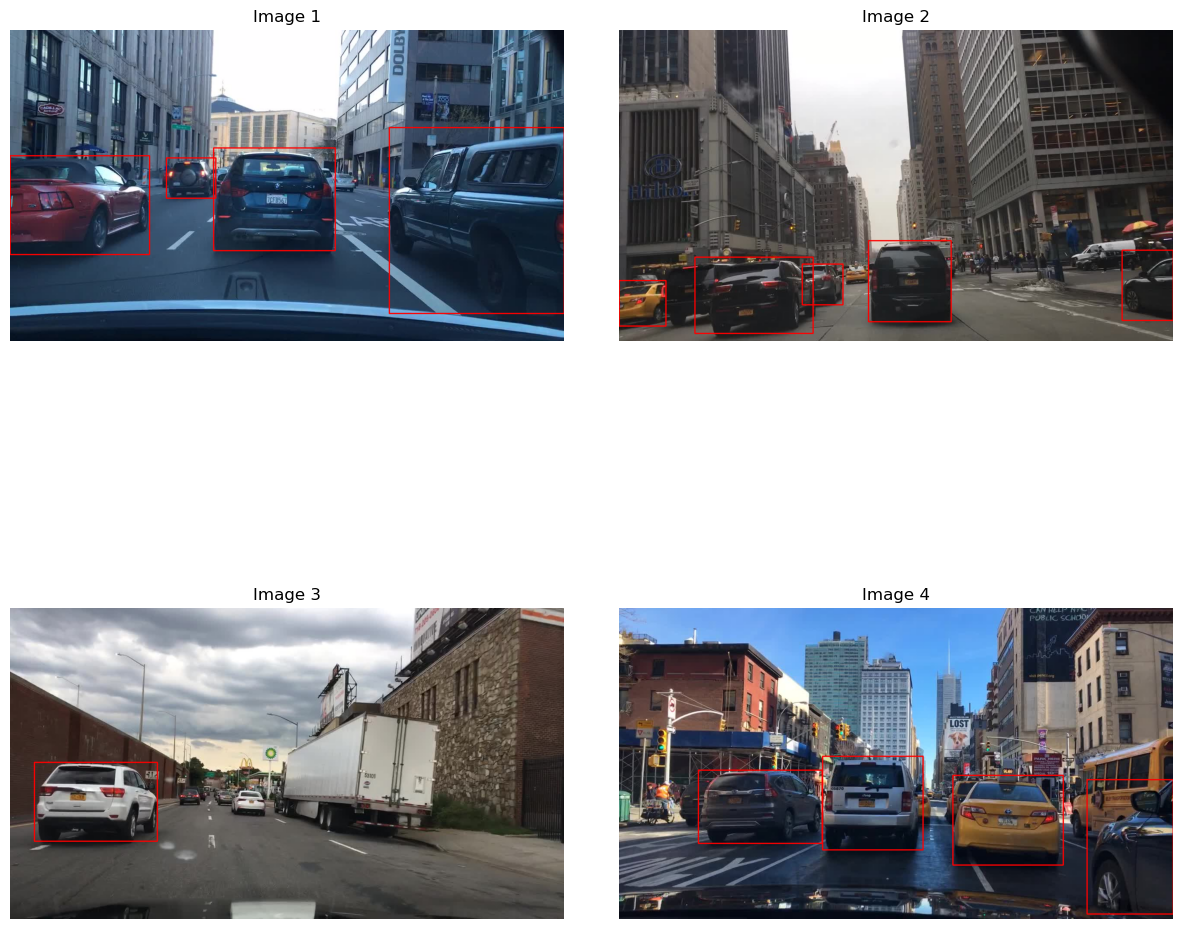

In [61]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots within a single figure
fig, axs = plt.subplots(2, 2,figsize=(15, 15))

# Display the images in the subplots
axs[0, 0].imshow(cv2.cvtColor(result[0], cv2.COLOR_BGR2RGB) )
axs[0, 0].axis('off')  # Optional: Turn off axis
axs[0, 0].set_title('Image 1')

axs[0, 1].imshow(cv2.cvtColor(result[1], cv2.COLOR_BGR2RGB))
axs[0, 1].axis('off')  # Optional: Turn off axis
axs[0, 1].set_title('Image 2')

axs[1, 0].imshow(cv2.cvtColor(result[2], cv2.COLOR_BGR2RGB))
axs[1, 0].axis('off')  # Optional: Turn off axis
axs[1, 0].set_title('Image 3')

axs[1, 1].imshow(cv2.cvtColor(result[3], cv2.COLOR_BGR2RGB))
axs[1, 1].axis('off')  # Optional: Turn off axis
axs[1, 1].set_title('Image 4')

# Remove empty subplots
# axs[1, 1].remove()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.0)

# Show the plot
plt.show()


## 3. Detect from a Video

In [21]:
cap = cv2.VideoCapture('video11.mp4')
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# ****** Save Output Video 
# Get the frames per second (fps) and frame size of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))
# frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# Define the codec to use for saving the video
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change the codec here, e.g., 'MJPG', 'X264', etc.

# Create a VideoWriter object to save the video
output_path = 'output.avi'  # Replace with the path to save your output video
out = cv2.VideoWriter(output_path, fourcc, fps, frame_size, isColor=True)
# ******

while cap.isOpened(): 
    ret, frame = cap.read()
    cv2.resize(frame,(800,600))
    df = vehicle_detection_data_frame(image=frame,detect_fn=detect_fn)
    # Write the frame to the output video
    out.write(frame)
    cv2.imshow('object detection',  cv2.resize(frame, (800, 600)))
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

[{'score': 0.8725246, 'class': 0, 'box': [659, 817, 920, 1126]}, {'score': 0.67323154, 'class': 0, 'box': [673, 1702, 1063, 1914]}]
[{'score': 0.80368334, 'class': 0, 'box': [653, 816, 921, 1129]}, {'score': 0.7018361, 'class': 0, 'box': [675, 1693, 1065, 1913]}]
[{'score': 0.84197813, 'class': 0, 'box': [653, 812, 923, 1123]}, {'score': 0.67077726, 'class': 0, 'box': [671, 1689, 1063, 1912]}]
[{'score': 0.82004005, 'class': 0, 'box': [649, 811, 921, 1123]}, {'score': 0.63916874, 'class': 0, 'box': [637, 1680, 1071, 1916]}]
[{'score': 0.83923256, 'class': 0, 'box': [656, 807, 923, 1130]}, {'score': 0.62725526, 'class': 0, 'box': [635, 1675, 1068, 1916]}]
[{'score': 0.8326284, 'class': 0, 'box': [657, 811, 923, 1126]}, {'score': 0.65444887, 'class': 0, 'box': [613, 1673, 1068, 1916]}]
[{'score': 0.7850558, 'class': 0, 'box': [646, 806, 916, 1123]}, {'score': 0.6532972, 'class': 0, 'box': [605, 1659, 1063, 1918]}]
[{'score': 0.81275386, 'class': 0, 'box': [644, 806, 918, 1118]}, {'score'

[{'score': 0.93878657, 'class': 0, 'box': [620, 1345, 952, 1916]}, {'score': 0.7573219, 'class': 0, 'box': [631, 729, 968, 1126]}]
[{'score': 0.9505619, 'class': 0, 'box': [629, 1339, 946, 1910]}, {'score': 0.70020366, 'class': 0, 'box': [628, 724, 968, 1123]}]
[{'score': 0.95341134, 'class': 0, 'box': [635, 1336, 945, 1913]}, {'score': 0.7714542, 'class': 0, 'box': [632, 722, 968, 1124]}]
[{'score': 0.9537888, 'class': 0, 'box': [640, 1337, 941, 1893]}, {'score': 0.790323, 'class': 0, 'box': [630, 724, 970, 1127]}]
[{'score': 0.97412384, 'class': 0, 'box': [637, 1328, 942, 1891]}, {'score': 0.7891213, 'class': 0, 'box': [628, 721, 970, 1131]}]
[{'score': 0.9729864, 'class': 0, 'box': [639, 1326, 940, 1879]}, {'score': 0.8783637, 'class': 0, 'box': [627, 727, 967, 1132]}]
[{'score': 0.9555981, 'class': 0, 'box': [644, 1321, 939, 1861]}, {'score': 0.85402983, 'class': 0, 'box': [629, 728, 965, 1132]}]
[{'score': 0.95739776, 'class': 0, 'box': [652, 1322, 936, 1848]}, {'score': 0.8786487

[{'score': 0.756286, 'class': 0, 'box': [688, 1151, 846, 1388]}, {'score': 0.66439223, 'class': 0, 'box': [638, 741, 978, 1144]}]
[{'score': 0.8089032, 'class': 0, 'box': [685, 1150, 842, 1375]}, {'score': 0.7349, 'class': 0, 'box': [643, 741, 976, 1148]}]
[{'score': 0.6911501, 'class': 0, 'box': [650, 739, 978, 1151]}, {'score': 0.6666757, 'class': 0, 'box': [690, 1151, 843, 1374]}]
[{'score': 0.7998624, 'class': 0, 'box': [685, 1157, 841, 1368]}, {'score': 0.7442011, 'class': 0, 'box': [631, 739, 973, 1149]}]
[{'score': 0.8500241, 'class': 0, 'box': [631, 741, 976, 1146]}, {'score': 0.79928505, 'class': 0, 'box': [685, 1143, 835, 1361]}]
[{'score': 0.7762646, 'class': 0, 'box': [633, 742, 976, 1148]}, {'score': 0.7180051, 'class': 0, 'box': [685, 1149, 833, 1356]}]
[{'score': 0.8206366, 'class': 0, 'box': [635, 742, 974, 1145]}]
[{'score': 0.8272289, 'class': 0, 'box': [633, 744, 973, 1143]}, {'score': 0.62338656, 'class': 0, 'box': [684, 1154, 828, 1347]}]
[{'score': 0.8285561, 'cla